<a href="https://colab.research.google.com/github/akhsassoualid/Prediction_of_making_a_deposit_by_clients/blob/master/Prediction_of_making_a_deposit_term_by_client.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**

**1.Import important libraries**

**2.Define usable functions**

**3.Import, Manipulate, explore visually, and scale data**
 - 3.1.Import data, drop unnecessary variables:
 - 3.2. Explore categorical data visually
 - 3.3. Explore correlation of numerical data

**4.Filtering out low variance and highly correlated features**
 - 4.1. Filtering out highly correlated features
 - 4.2. Filtering out low variance features

**5.Fit multiple classifiers:**
 - 5.1. Label encoder for categorical variables
 - 5.2. Fit multiple classifier using the built functions "grid_model"
    
     - 5.2.1. Fit a KNN Classifier and DecisionTress Classifier with a GridSearch
    
     - 5.2.2. Fit a Bagged classifier with a base learner 'Decision Tree'
    
     - 5.2.3. Fit a Random Forest classifier with a GridSearch
    
     - 5.2.4. Fit a Logistic Regression with a GridSearch
    
     - 5.2.5. Feature importance based on Decision Tree model , Random Forest, and Logistic Regression

**6.To sum up:**


**Introduction**

---


In the following python project, the data concerns a bank's marketing strategy, **The purpose is to figure out how possible this strategy could attract more clients to term deposit subscription**. A term deposit is a fixed-term investment where the customer deposits funds in an account at a financial institution, and carry short-term maturities ranging from one month to a few years.

The data we got is mixed data, it contains in total 21 categorical and numerical features. **The project aims to exploit these informations about clients to predict whether they will choose a term deposit, to specify the principal axes on which the bank can rely on to attract more customers for such a product.**

We need to sheed light on some variables. The **duration** feature need to be dropped, since it highly affects the output target ( In fact, if duration=0 then y='no', if duration=1 then y=1), so this attribute will be included for benchmark purposes and dropped from data.
For **pdays** attribute, the data description confirm that if pdays=999 it means client was not previously contacted so we aim to replace 999 with 0 and not 999.

The project aims for **EXPLORATION** and then **EXPLOITATION**. We will import the bank marketing data, manipulate, and perform some descriptive statistics, and graphical exploring, then prepare it for the step of modeling and concluding main results.

***1.   Import important libraries***

---



In [0]:
# Imported libraries for dataframes, arrays, and plots
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries to preprocess the data
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, RFE

# Libraries of modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

# Library for metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, balanced_accuracy_score

***2. Define usable functions***

---



In [0]:
# Define Function of descriptive statistics
def explor(data):
    print(data.info())
    # detect missing values
    x = data.isnull().sum()
    # detect missing values
    if sum(x)==0:
        print('There are no missed values')
    else:
        for i in np.arange(0,len(x)):
            if x[i]!=0:
                print('There are '+str(x[i])+' missied value in the column '+ x.index[i])

# Build a function to run multiple models at once
def grid_model(estim, param, CV, X_tr, X_te, y_tr, y_te):
    gr_estimator= GridSearchCV(estimator = estim, param_grid = param, cv=CV, scoring = 'f1')
    gr = gr_estimator.fit(X_tr, y_tr)
    model = gr.best_estimator_
    y_pred = model.predict(X_te)
    print("The BEST PARAMETERS are:{}".format(gr.best_params_))
    print("The best model results a BALANCED ACCURACY of {}:".format(round(gr.best_score_,2)))
    print("The F1-SCORE based on the model is:{}".format(round(f1_score(y_test, y_pred),2)))
    print("The ACCURACY based on the best model's predictions is:{}".format(round(accuracy_score(y_te, y_pred),3)))
    print("The AREA UNDER THE CURVE RATE is {}:".format(round(roc_auc_score(y_test, y_pred),2)))
    print(pd.DataFrame(confusion_matrix(y_te, y_pred), 
                       index = ['true negative', 'true positive'], columns=['predicted negative','predicted positive']))
    models.append(model)
    # Plot the ROC-Curve
    y_pred_prob = model.predict_proba(X_te)[:,1]
    fpr, tpr, threshold = roc_curve(y_te, y_pred_prob)
    plt.plot([0,1],[0,1], 'g--')
    plt.plot(fpr, tpr, label='The ROC-CURVE plot')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    return y_pred

# Define Function to plot feature importance
def feat_importance(model_name, estimator, variables):
  estimator.fit(X_train, y_train)
  if model_name == 'Decision Tree':
    var_impo = estimator.tree_.compute_feature_importances(normalize=False)
  elif model_name == 'Random Forest':
    var_impo = estimator.feature_importances_
  elif model_name == 'Logistic Regression':
    var_impo = estimator.coef_[0]
  dat = pd.DataFrame({'Variable':variables.tolist(),'Importance':var_impo.tolist()})
  sns.barplot(x="Importance",y="Variable", data=dat)
  plt.title('Features importance according to the model of '+model_name)
  plt.show()

  # Define Function for RFE with multiple selector
def rfe_select(X, y, estim, n_feat, stepp):
  rfe = RFE(estimator=estim, n_features_to_select=n_feat, step=stepp, verbose=1)
  rfe.fit(X,y)
  return rfe.support_


***3. Import, Manipulate, explore visually, and scale data***

---



***3.1. Import data, drop unnecessary variables:***

In [0]:
df = pd.read_csv('/content/bank-additional-full.csv', sep=';', comment='#', na_values='NA')
# Drop duration attribute
df = df.drop('duration', axis=1)
# Make the change on observation that have pdays=999
for i in range(0,len(df)):
    if df.loc[i,'pdays']==999:
        df.loc[i,'pdays']=0
df_original = df
# Select categorical and continuous features
categorical_mask = (df.dtypes == 'object')

In [5]:
# Descriptive Statistics of data 
explor(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

In [6]:
df.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,0.221229,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,2.770014,1.348874,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,0.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,2.000000,0.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,3.000000,0.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,56.000000,27.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [7]:
print('The size of data is {} observations and {} features:'.format(df.shape[0], df.shape[1]))

The size of data is 41188 observations and 20 features:


* Conclusions:

 - The data is composed of 41188 observations and 20 features, after dropping unnecessary variable "duration" since it affects directly the target variable.
 - The mean age of clients is equal to 40 years old
 - The scale of measures between numerical variables is quit different, so the data must be scaled before modeling.
  - there are 11 categorical and 9 numerical features including the target variables, and other 10 numerical features

***3.2. Explore categorical data visually***



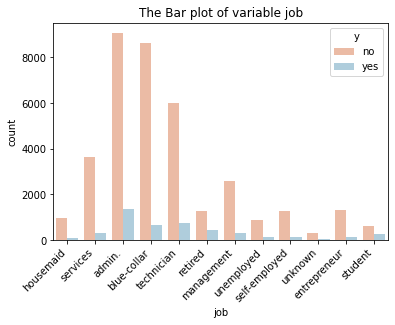

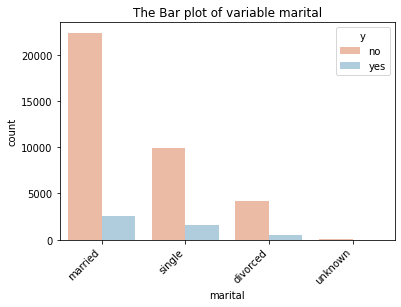

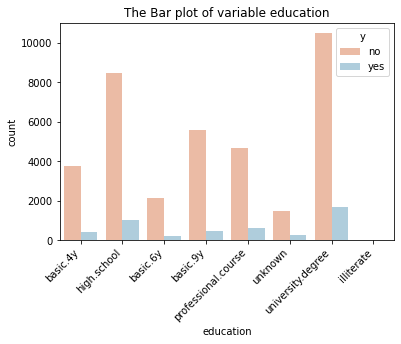

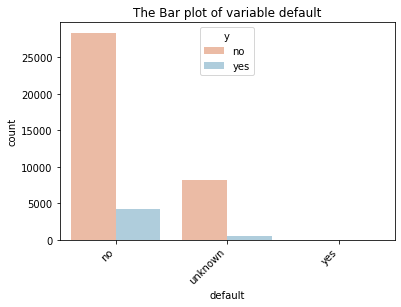

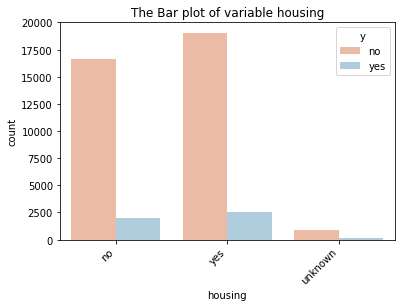

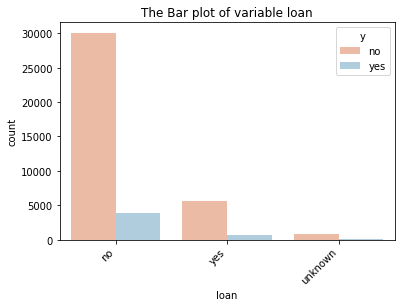

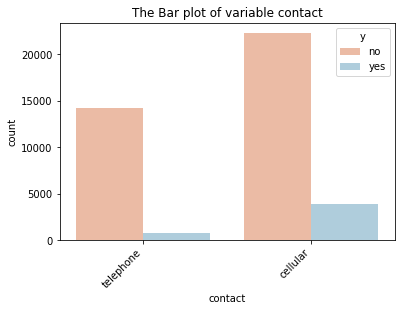

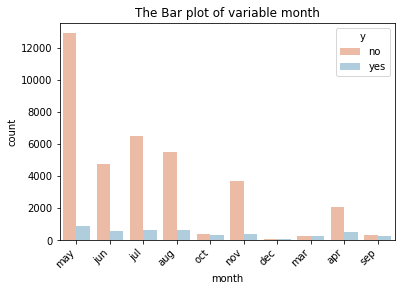

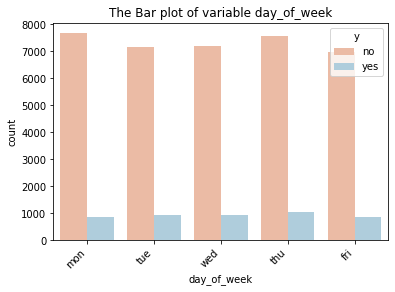

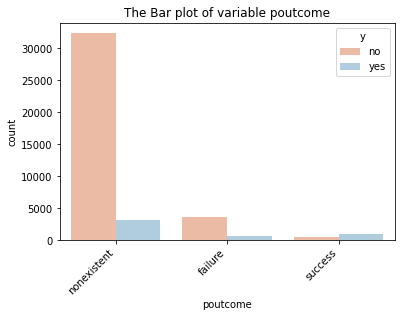

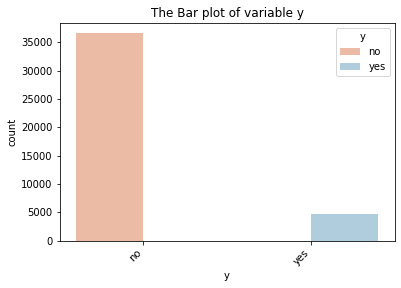

In [0]:
for var in df.columns[categorical_mask]:
  chart = sns.countplot(x=var, hue='y', data = df, palette="RdBu")
  chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
  plt.title('The Bar plot of variable '+var)
  plt.show()

*   Conclusions:
 - First look on the barplot of the target variable **y**, we notice a problem of unbalancing between its class, we have more observation with y=0 than those with y=1.

 - We noticed there is unknow data on some variables, we talk about: **"martial, default, housing, loan"**, we can assume that the number of unknown values for these variables is quite weak, so we consider them as a class of the concerned variables. However, we can impute these variables using **"fancyimpute"** module, to impute with KNN, but this will certainly cause a problem of multicollinearity between categorical variables, which allow the risk of overfitting.

 - The problem of unbalancing data is quite clear, it seems that the number of clients that refuse a deposit term is very important on each categorical feature.

 - The number of clients having these variable-class "job-admin.", "martial-married, "education-university degree" is so important. The majority of clients with these class refuse the bank's product

 - **First impression is that the new strategy must be focused on these class of these 3 variables, and look to make the majority of clients with these class accept the product.**

***3.3. Explore correlation of numerical data***

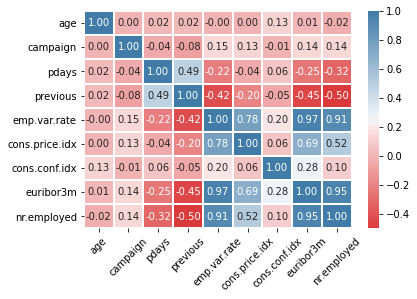

In [8]:
my_corr = df[df.columns[categorical_mask==False]].corr()
cmap = sns.diverging_palette(h_neg=12,h_pos=240, as_cmap=True)
sns.heatmap(round(my_corr,2),cmap=cmap,linewidths=1,annot = True,fmt=".2f", )
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

*   Conclusions:
 - The variables **"emp.var.rate, nr.employed, cons.conf.idx, euribor3m"** are the most correlated features with a correlation higher than 0.9, Therefore we should take into consideration this problem, before modeling.
 - We should shed light that the rest of the features aren't correlated, In that case we can be sure about the absence of any linear relation between them. It's a plus for a better model.

***4. Filtering out low variance and highly correlated features***

---


 
***4.1. Filtering out highly correlated features***

In [9]:
my_corr = my_corr.abs()
corr_mask = np.triu(np.ones_like(my_corr, dtype=bool))
tri = my_corr.mask(corr_mask)
to_drop = [c for c in tri.columns if any(tri[c] > 0.9)] ## we select variables wuth hight correlation to drop
print(' The feature that must be dropped are:'+str(to_drop))
df = df.drop(to_drop,axis=1)

 The feature that must be dropped are:['emp.var.rate', 'euribor3m']


We build a mask that select variables that cause a risk of multicollinearity, for that we drop from data **df** the variables: **"emp.var.rate, euribor3m".**

***4.2. Filtering out low variance features***

In [0]:
dfs =df
categorical_mask = (df.dtypes == 'object')
cont_var = df.columns[categorical_mask==False].tolist()
scaler = MinMaxScaler()
dfs[cont_var]=scaler.fit_transform(dfs[cont_var])

In [11]:
# Put the selector
selector = VarianceThreshold(0.001)
selector.fit(dfs[cont_var])
mask = selector.get_support().tolist()
if all(mask):
    print('No Features can be elimiated')
else:
    s=df.shape[1]
    df = df.drop([cont_var[mask==False]], axis=1)
    print('Dimensionality of reduced from {} to {}.'.format(s, df.shape[1]))

No Features can be elimiated


It seems that all variable have important variance, so no features can be elimnated.

***5. Fit multiple classifiers:***

---

***5.1. Label encoder for categorical variables***

In [0]:
le = LabelEncoder()
for var in df.columns[categorical_mask==True].tolist():
    df[var]=le.fit_transform(df[var])

***5.2. Fit multiple classifier using the built functions "grid_model"***

To note that we haven't ignored the problem of unbalanced data, in fact we can see it throw the following tables:

In [0]:
# Spiliting original data 
X = df.drop('y', axis=1)
y = df['y']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.25,random_state=100)
# Spiliting scaled data 
Xs = dfs.drop('y', axis=1)
ys = dfs['y']
Xs_train, Xs_test, ys_train, ys_test=train_test_split(Xs,ys,test_size=0.25,random_state=100)

In [14]:
print(round((df['y'].value_counts()/len(df))*100,2))
print(round((y_train.value_counts()/len(y_train))*100,2))
print(round((y_test.value_counts()/len(y_test))*100,2))

0    88.73
1    11.27
Name: y, dtype: float64
0    88.7
1    11.3
Name: y, dtype: float64
0    88.85
1    11.15
Name: y, dtype: float64


We have approximately the same percentage of each class in train and test sets, but we notice the problem of unbalanced data we talk about.

**To note that the capacities of our machine are limited, which consume more time to get the results, so we tried as possible to get the best models.**

***5.2.1. Fit a KNN Classifier and DecisionTress Classifier with a GridSearch***

Right now, we are sure that the data is unbalanced, so it seems logical to wait for a high level of accuracy but a low rate of precision and sensitivity (we measure both of them with the F1-Score). In that case, the built function **grid_model**, which is a function that allows us to run multiple classifiers and get the necessary metrics rapidly, with a grid search to tune hyperparameters, we will select the best one in function to a scoring parameter called 'balanced accuracy'.
In fact, we used before other scoring parameters such as the F1 score and area under the curve score, but the results show the impact of unbalanced data.

**KNN need to be fitted on scaled data.**

The BEST PARAMETERS are:{'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}
The best model results a BALANCED ACCURACY of 0.58:
The F1-SCORE based on the model is:0.26
The ACCURACY based on the best model's predictions is:0.875
The AREA UNDER THE CURVE RATE is 0.58:
               predicted negative  predicted positive
true negative                8790                 359
true positive                 927                 221


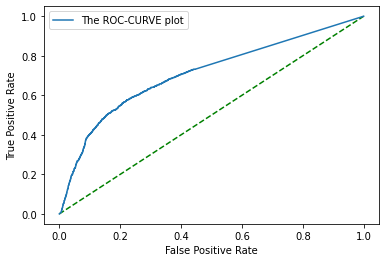

The BEST PARAMETERS are:{'class_weight': 'balanced', 'max_depth': 10, 'max_leaf_nodes': 70, 'min_samples_leaf': 40, 'min_samples_split': 2}
The best model results a BALANCED ACCURACY of 0.75:
The F1-SCORE based on the model is:0.44
The ACCURACY based on the best model's predictions is:0.822
The AREA UNDER THE CURVE RATE is 0.74:
               predicted negative  predicted positive
true negative                7745                1404
true positive                 426                 722


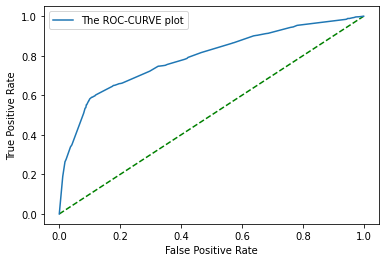

In [0]:
# Fit a KNN Classifier with a GridSearch
knn_param = {'n_neighbors':[10,20,45,65], 
             'weights':['uniform','distance'],'metric':['manhattan'],
             }
knn_pred = grid_model(KNeighborsClassifier(), knn_param,10, Xs_train, Xs_test, ys_train, ys_test)
# Fit a Decision Tree Classifier with a GridSearch
dt_param={"max_depth": [10,17,25],
          "max_leaf_nodes": [70,90,110], ## max leaves in a tree
          "min_samples_leaf": [30,40,45,50], ## minimum number of samples required to be at a leaf node
          "min_samples_split": [2,3,5,10], 'class_weight':['balanced']}
dt_pred = grid_model(DecisionTreeClassifier(), dt_param, 10, X_train, X_test, y_train, y_test)

***5.2.2. Fit a Bagged classifier with a base learner 'Decision Tree'***

The OOB-score is equal to:0.85
The F1-SCORE based on the model is:0.47
The ACCURACY based on best model's predictions is:0.85
The AREA UNDER THE CURVE RATE is equal to:0.74
               predicted negative  predicted positive
true negative                8075                1074
true positive                 467                 681


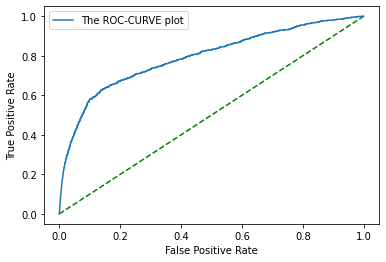

In [0]:
## 5.2.3 Fit a Bagged classifier with a base learner 'Decision Tree' and a GridSearch
dt = DecisionTreeClassifier(max_depth=10, max_leaf_nodes=70, min_samples_leaf=40, min_samples_split=2, class_weight='balanced')
bg = BaggingClassifier(base_estimator=dt, n_estimators=600, oob_score=True,n_jobs=-1,random_state=100)
bg_model = bg.fit(X_train, y_train)
bg_pred = bg.predict(X_test)
print('The OOB-score is equal to:{}'.format(round(bg.oob_score_,2)))
print("The F1-SCORE based on the model is:{}".format(round(f1_score(y_test, bg_pred),2)))
print("The ACCURACY based on best model's predictions is:{}".format(round(accuracy_score(y_test, bg_pred),2)))
print('The AREA UNDER THE CURVE RATE is equal to:{}'.format(round(roc_auc_score(y_test, bg_pred),2)))
print(pd.DataFrame(confusion_matrix(y_test, bg_pred), 
                       index = ['true negative', 'true positive'], columns=['predicted negative','predicted positive']))
# Plot the ROC-Curve
bg_pred_prob = bg_model.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, bg_pred_prob)
plt.plot([0,1],[0,1], 'g--')
plt.plot(fpr, tpr, label='The ROC-CURVE plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

*   Conclusions:
 - We fitted three models, the first two are KNN and Decision Tree classifiers, and a bagging model with decision tree as a based learner. it seems that with the chosen scoring parameters, grid search performed well.

 - If we think according to accuracy, we have 0.875 for KNN, 0.822 for decision tree and 0.85 for bagging, so we would say the KNN is the best choice to model this data. **However :**

 - If we take a look at the f1- score, we have {0.26 - KNN, 0.44 - Decision tree, 0.47 - Bagging}. In that case we would say it's bagging with decision tree as a based learner. 
 
  - If we take a look on the area under the curve, we will notice that KNN performs the lowest one {0.58}, while Decision Tree and bagging have the same ROC-curve area {0.74}, which is quite acceptable, and show good performance of both classifier, so we would say that best model is bagged model or the Decision tree model.
 
 - To sum up, the metrics show that bagging with decision tree as a based learner is the best choice we can make. 

***5.2.3. Fit a Random Forest classifier with a GridSearch***

The BEST PARAMETERS are:{'class_weight': 'balanced', 'max_depth': 17, 'max_leaf_nodes': 110, 'min_samples_leaf': 30, 'min_samples_split': 5, 'n_estimators': 300}
The best model results a BALANCED ACCURACY of 0.75:
The F1-SCORE based on the model is:0.47
The ACCURACY based on the best model's predictions is:0.848
The AREA UNDER THE CURVE RATE is 0.74:
               predicted negative  predicted positive
true negative                8028                1121
true positive                 447                 701


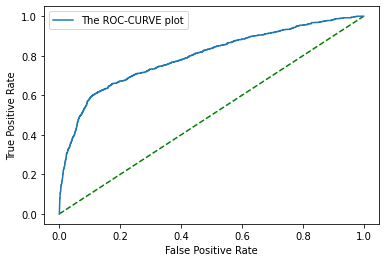

In [0]:
### 5.2.4 Fit a Random Forest classifier with a GridSearch
rf_param = {'n_estimators':[300],
            "max_depth": [10,17,25],
            "max_leaf_nodes": [70,90,110], ## max leaves in a tree
            "min_samples_leaf": [30,40,45,50], ## minimum number of samples required to be at a leaf node
            "min_samples_split": [2,3,5,10], 'class_weight':['balanced']}
rf_pred = grid_model(estim=RandomForestClassifier(), param=rf_param, CV=10, X_tr=X_train, X_te=X_test, y_tr=y_train, y_te=y_test)

*   Conclusions:
 - We could run several Random Forest models with a multi choice number of estimator, but the capacities of the machine are limited.
 - For the ROC-curve area, and f1-score, we got 0.47 the same results as a bagged model. However, we got an accuracy of 0.848 approximately equal to bagging's accuracy of 0.85, so with random forest there is no important increasement.
 - As we haven't yet got a model with an f1-score higher than 0.5, we still not have a good model with good performance. To note that the machine could not help to tune more hyperparameters.

***5.2.4. Fit a Logistic Regression with a GridSearch***

The BEST PARAMETERS are:{'C': 1, 'class_weight': 'balanced', 'penalty': 'l2'}
The best model results a BALANCED ACCURACY of 0.73:
The F1-SCORE based on the model is:0.4
The ACCURACY based on the best model's predictions is:0.775
The AREA UNDER THE CURVE RATE is 0.73:
               predicted negative  predicted positive
true negative                7216                1933
true positive                 388                 760


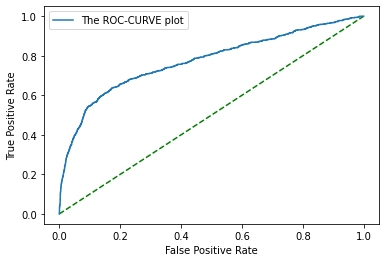

In [0]:
lr_param = {"penalty":["l2"], 
            "C":[0.1,0.5, 1,5,10], "class_weight":['balanced']}
lr_pred = grid_model(LogisticRegression(max_iter=700), lr_param, 10, Xs_train, Xs_test, ys_train, ys_test)

*   Conclusion:
 - The logistic regression haven't results any important increasement for the evaluation's metrics.
 - However, we can use the statistical approach of logistic regression to evaluate the significance of features.

***5.2.5. Feature importance based on Decision Tree model , Random Forest, and Logistic Regression***

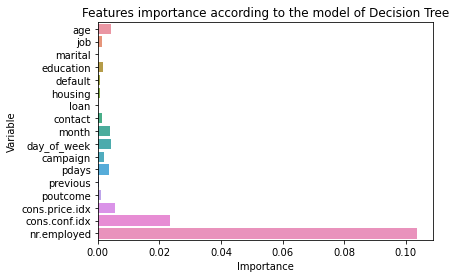

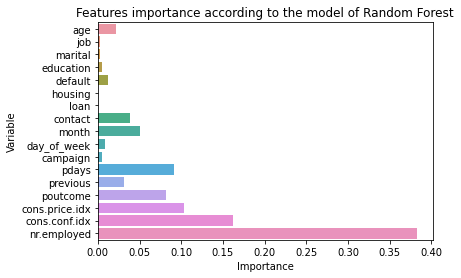

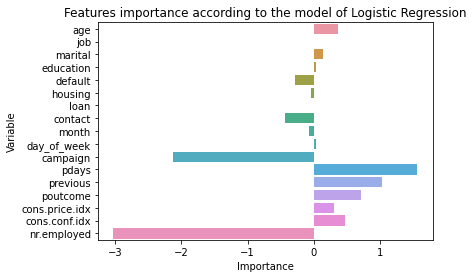

In [0]:
feat_importance(model_name="Decision Tree", estimator=models[1], variables=X.columns)
feat_importance(model_name="Random Forest", estimator=models[3], variables=X.columns)
feat_importance(model_name='Logistic Regression', estimator=models[-1], variables=X.columns)

*   Conclusion:
 - Decision Tree and Random Forest prove that **nr.employed** and **cons.conf.idx** variables are the most important variable by far in comparison to the rest of the features.
 - The decision tree shows that the rest of variables have approximately zero importance, while the random forest sheds light on some features that perform significant importance. 
 - **So if there is any built strategy, it needs to focus on nr.employed and cons.conf.idx variables.**
 - Logistic Regression insists on the importance of **nr.employed**, but also of **pdays** ad **compaign**. 
 - **"nr.employed" and "compaign" make the probability that a client accepts the products increases, while if "pdays" increases it impact the probability of accepting a product negatively.**

***6. To sum up***

---


 - We can say that all the models give approximate results in general.
 - These results are acceptable since at least the f1-score is approximately equal to 50%.
 - The bagged model gives the best results according to all metrics. We can say that the decision tree and random forest give good results too.
 - Any increasement of **nr.employed** and **compain** increase the probability that a client accept a term deposit.
 - Any increasement of pdays decrease the probability that a client accept a term deposit.
 - As conclusion, the bank should build its strategy on improving these features, since the models show their importance on the probability of accepting the new product.
  - To note that we could use other algorithms (AdaBoost, GBMBoost, XgBoost) to fit predictions, but they require a machine with high capacities. 